Running LDA and K-means Clustering to separate spatio-temporal patterns of dynamic functional connectivity between groups

In [1]:
#scikit learn - LDA
import os
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load & Prepare the Data

In [53]:
data_dir = '/Users/ntaylor/Library/CloudStorage/OneDrive-TheUniversityofSydney(Staff)/Postdoc_Rob/Analysis/Graph_Theory/schaef_400'
# Change the current working directory to the data directory
os.chdir(data_dir)
# Assume `features` is a NumPy array or DataFrame with dynamic functional connectivity features
# Assume `labels` is a NumPy array or Series with group labels (e.g., 0 for group 1, 1 for group 2)
data = pd.read_csv('mtd_nbm_avg_allsubstime.csv',header=None)  # Replace with your data file
# Print the size of the DataFrame
print(f"DataFrame shape: {data.shape}")  # Outputs (number of rows, number of columns)

# Optionally, print the number of rows and columns separately
print(f"Number of rows: {data.shape[0]}")
print(f"Number of columns: {data.shape[1]}")
# mtd_lc_avg_allsubs.csv #mtd_ppn_avg_allsubs.csv
n_rois = 502 # Number of ROIs
n_subjects = 119 # number of subjects
n_timepoints = 210 # timepoints
# Reshape to subject x time x ROI
#data = np.transpose(data, (0, 2, 1))  # Now shape is (subject, time, ROI)
# Example input for name_suffix
name_suffix = "mtd_nbm"

DataFrame shape: (24990, 502)
Number of rows: 24990
Number of columns: 502


In [4]:
print(f"Shape of data: {data.shape}")  # Should be (n_subjects, n_rois * n_timepoints)

Shape of data: (24990, 502)


In [33]:
labels = pd.read_csv('delirium_idx.csv',header=None) 

# Create expanded labels to match the new shape
expanded_labels_time = np.repeat(labels, n_timepoints)

# Perform LDA and Split by Group
Apply Linear Discriminant Analysis (LDA) to the dataset and split the resulting projections by group (e.g., control and delirium).

# (Subjects, time * ROIs):
Captures group differences across the entire temporal trajectory, preserving temporal structure

In [5]:
# Assume the following dimension
features = data.values  # Convert DataFrame to NumPy array
# Reshape from (subjects * time, ROIs) to (subjects, time, ROIs)
reshaped_features = features.reshape(n_subjects, n_timepoints, n_rois)

# Flatten the (time, ROIs) dimensions to get (subjects, time * ROIs)
reshaped_features = reshaped_features.reshape(n_subjects, -1)  # Shape: (subjects, time * ROIs)

print("Reshaped features shape:", reshaped_features.shape)

Reshaped features shape: (119, 105420)


In [ ]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(reshaped_features)  # Shape: (subjects, time * ROIs)

# Apply LDA
lda = LinearDiscriminantAnalysis(priors=[0.5, 0.5])
X_lda = lda.fit_transform(features_scaled, labels.values.ravel())  # Shape: (subjects, 1)

# Separate groups based on labels
control_proj = X_lda[labels.values.ravel() == 0]  # Non-delirious group
delirium_proj = X_lda[labels.values.ravel() == 1]  # Delirium group

# Plot mean and standard deviation of LDA projections
# Define custom labels and colors for the groups
group_labels = {0: "Non-Delirious", 1: "Delirious"}
group_colors = ["#fdcd9a","#aed8e6"]  # List of colors corresponding to the groups

# Create a DataFrame for plotting
import pandas as pd
plot_data = pd.DataFrame({
    'Group': [group_labels[label] for label in labels.values.ravel()],  # Map numeric labels to group names
    'LDA Component 1': X_lda.flatten()  # Flatten LDA projections
})

# Boxplot with individual points
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='LDA Component 1', data=plot_data, palette=group_colors, showfliers=False)
sns.stripplot(x='Group', y='LDA Component 1', data=plot_data, palette=group_colors, jitter=True, alpha=0.7)

# Add title and labels
plt.title('Boxplot of LDA Component by Group with Individual Points')
plt.xlabel('Group')
plt.ylabel('LDA Component 1')
plt.grid(axis='y')  # Add gridlines only to the y-axis for better readability

# Save the figure as an SVG file
output_dir = '/Users/ntaylor/Library/CloudStorage/OneDrive-TheUniversityofSydney(Staff)/Postdoc_Rob/Analysis/Graph_Theory/schaef_400/PCA_LDA/Python/'
output_path = os.path.join(output_dir, f"lda_subject_time_{name_suffix}_ROI_boxplot.svg")
plt.savefig(output_path, format="svg", bbox_inches="tight")

plt.show()

# Transforming the Data into low-dimension embedding

What fit_transform Does:
Fits the LDA Model:
1. Finds the linear discriminant axes that maximize the separation between the groups.
Projects the Data:
2. Projects the input data (features_scaled) into the LDA subspace, resulting in a lower-dimensional representation (X_lda).

In [ ]:
# Reshape LDA coefficients to (time, ROIs)
lda_coefficients = lda.coef_  # Shape: (1, time * ROIs)
lda_coefficients_reshaped = lda_coefficients.reshape(n_timepoints, n_rois)  # Shape: (time, ROIs)

# Plot contributions of ROIs over time
plt.figure(figsize=(12, 8))
for roi in range(0, n_rois, 50):  # Plot every 50th ROI to reduce clutter
    plt.plot(range(n_timepoints), lda_coefficients_reshaped[:, roi], label=f'ROI {roi + 1}')

plt.title('Contributions of Selected ROIs to LDA Group Separation Over Time')
plt.xlabel('Time')
plt.ylabel('LDA Coefficient')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(lda_coefficients[0])  # Plot all coefficients
plt.title("LDA Coefficients")
plt.xlabel("Feature Index")
plt.ylabel("Coefficient Value")
plt.show()

# Top time-points that differentiate the groups
1. Sum or Aggregate ROI Contributions for Each Time Point:
Since the LDA coefficients are reshaped to (time, ROIs), you can compute the sum of the absolute values of the coefficients across all ROIs for each time point. This gives you a single importance score for each time point.
2. Rank the Time Points:
Rank the time points based on their importance scores in descending order.
3. Select the Top Time Points:
Extract the indices of the top time points and their corresponding scores.
4. Visualize or Output the Results:
Highlight the top time points in a plot or print them.

Top time points that distinguish the groups:
Rank 1: Time Point 93, Score: 0.0137
Rank 2: Time Point 187, Score: 0.0137
Rank 3: Time Point 122, Score: 0.0135
Rank 4: Time Point 152, Score: 0.0135
Rank 5: Time Point 77, Score: 0.0134


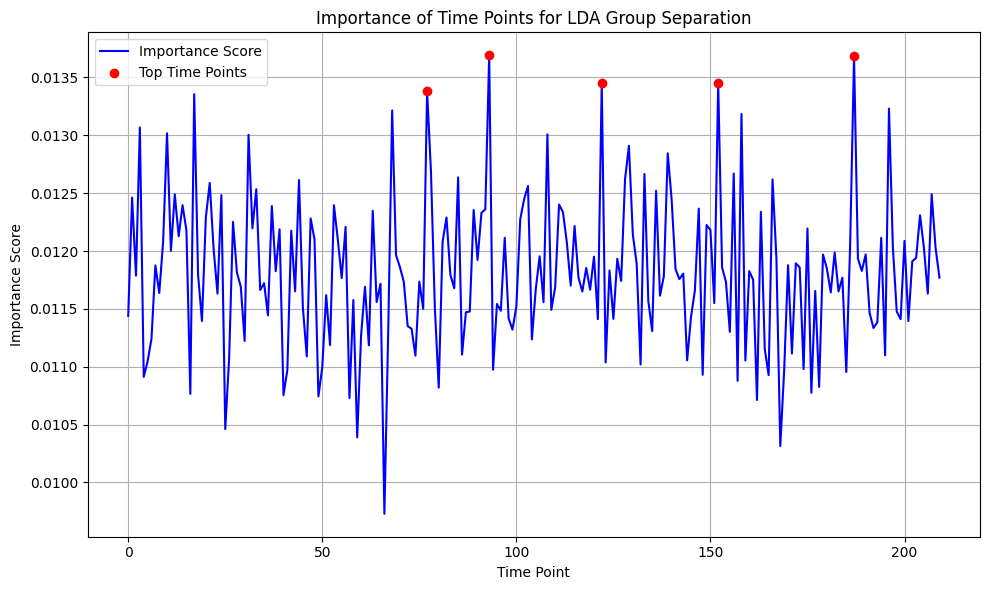

In [9]:
# Step 1: Compute importance scores for each time point
time_point_scores = np.sum(np.abs(lda_coefficients_reshaped), axis=1)  # Sum of absolute values across ROIs

# Step 2: Rank time points by importance
top_time_indices = np.argsort(time_point_scores)[::-1]  # Indices of time points sorted by descending importance
top_time_scores = time_point_scores[top_time_indices]  # Corresponding scores

# Step 3: Select the top N time points
top_n = 5  # Number of top time points to select
top_time_points = top_time_indices[:top_n]
top_scores = top_time_scores[:top_n]

# Print the top time points and their scores
print("Top time points that distinguish the groups:")
for i, (time_point, score) in enumerate(zip(top_time_points, top_scores)):
    print(f"Rank {i + 1}: Time Point {time_point}, Score: {score:.4f}")

# Step 4: Visualize the importance scores
plt.figure(figsize=(10, 6))
plt.plot(range(n_timepoints), time_point_scores, label="Importance Score", color="blue")
plt.scatter(top_time_points, top_scores, color="red", label="Top Time Points", zorder=5)
plt.title("Importance of Time Points for LDA Group Separation")
plt.xlabel("Time Point")
plt.ylabel("Importance Score")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

From the top time points - low-dimensional embedding of the average difference between two groups based on the original dFC data

In [ ]:
# Step 1: Extract the top time points from the original feature data
top_time_features = features.reshape(n_subjects, n_timepoints, n_rois)[:, top_time_points, :]  # Shape: (subjects, top_n, ROIs)

# Flatten the (time, ROIs) dimensions into a single feature vector for each subject
top_time_features_flattened = top_time_features.reshape(n_subjects, -1)  # Shape: (subjects, top_n * ROIs)

# Step 2: Project the original full feature set into the LDA subspace
lda_projections = lda.transform(features_scaled)  # Shape: (subjects, n_components)

# Step 3: Analyze the contributions of the top time points
# Use lda.coef_ to interpret the contributions of the original features
lda_coefficients = lda.coef_.reshape(n_timepoints, n_rois)  # Shape: (time, ROIs)

# Extract the coefficients for the top time points
top_time_coefficients = lda_coefficients[top_time_points, :]  # Shape: (top_n, ROIs)

# Step 4: Visualize the contributions of ROIs for the top time points
plt.figure(figsize=(12, 8))
for i, time_point in enumerate(top_time_points):
    plt.plot(range(n_rois), top_time_coefficients[i, :], label=f"Time Point {time_point}")

plt.title("Contributions of ROIs to LDA Group Separation at Top Time Points")
plt.xlabel("ROI")
plt.ylabel("LDA Coefficient")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Attempt to analyse the original data now that we have separate the groups based on the feature sub-space

In [ ]:
# Compute the absolute importance of each feature
feature_importance = np.abs(lda_coefficients)

# Identify the top ROIs and time points
top_time_indices = np.argsort(np.sum(feature_importance, axis=1))[::-1][:5]  # Top 5 time points
top_roi_indices = np.argsort(np.sum(feature_importance, axis=0))[::-1][:5]  # Top 5 ROIs

print("Top Time Points:", top_time_indices)
print("Top ROIs:", top_roi_indices)

Back project of the LDA sepation - try to reconstruct the original feature spaced based on the LDA separation 

In [ ]:
# Back-project the LDA projections into the original feature space
lda_back_projection = np.dot(lda_projections, lda.coef_)  # Shape: (subjects, time * ROIs)

# Reshape back to (subjects, time, ROIs)
lda_back_projection_reshaped = lda_back_projection.reshape(n_subjects, n_timepoints, n_rois)

# Visualize the back-projected data for a specific subject
subject_idx = 0  # Change this to visualize a different subject
plt.figure(figsize=(12, 8))
plt.imshow(lda_back_projection_reshaped[subject_idx], aspect='auto', cmap='coolwarm')
plt.colorbar(label="Back-Projected Value")
plt.title(f"Back-Projected Data for Subject {subject_idx + 1}")
plt.xlabel("ROIs")
plt.ylabel("Time Points")
plt.tight_layout()
plt.show()

In [ ]:
# Compute group-level averages of the back-projected data
control_back_projection = lda_back_projection_reshaped[labels.values.ravel() == 0].mean(axis=0)  # Shape: (time, ROIs)
delirium_back_projection = lda_back_projection_reshaped[labels.values.ravel() == 1].mean(axis=0)  # Shape: (time, ROIs)

# Compute the difference between the groups
group_difference = delirium_back_projection - control_back_projection

# Visualize the group-level difference as a heatmap
plt.figure(figsize=(12, 8))
plt.imshow(group_difference, aspect='auto', cmap='coolwarm')
plt.colorbar(label="Group Difference (Delirium - Non-Delirious)")
plt.title("Group-Level Differences in Back-Projected Data")
plt.xlabel("ROIs")
plt.ylabel("Time Points")
plt.tight_layout()
plt.show()

Select the top time points that differentiate - then calculate the brain plots from there

In [ ]:
# Step 1: Reshape the original feature data to (subjects, time, ROIs)
reshaped_features = features.reshape(n_subjects, n_timepoints, n_rois)  # Shape: (subjects, time, ROIs)
# Step 2: Extract the data for the top time points
top_time_features = reshaped_features[:, top_time_points, :]  # Shape: (subjects, top_n, ROIs)

print(f"Shape of data: {top_time_features.shape}")  # Should be (n_subjects, n_rois * n_timepoints)

# Trying to plot this on the brain

In [ ]:
print("Current working directory:", os.getcwd())

In [ ]:
# Iterate through the top 5 time point features
for time_point_idx in range(5):  # Assuming top 5 time points
    # Select top time features to plot difference
    selected_time_features = top_time_features[:, time_point_idx, :]  # Shape: (n_subjects, n_rois)
    
    # Separate data into groups
    control_data = selected_time_features[labels.values.ravel() == 0]  # Non-delirious group
    delirium_data = selected_time_features[labels.values.ravel() == 1]  # Delirium group
    
    # Compute group-level differences (e.g., mean difference)
    group_difference = delirium_data.mean(axis=0) - control_data.mean(axis=0)  # Shape: (n_rois,)
    
    # Select the first `rois_select` ROIs
    roi_data = group_difference
    
    # Reshape to (n_rois, 1)
    flattened_feature_select = roi_data.reshape(-1, 1)
    
    # Create a DataFrame
    df = pd.DataFrame(flattened_feature_select)
    
    # Save the DataFrame to a CSV file with the time point in the filename
    output_filename = f'grp_diff_timepoint_{time_point_idx + 1}_{name_suffix}.csv'
    df.to_csv(output_filename, index=False)
    
    print(f"Saved: {output_filename}")

## Relationship between the LDA separated time points (peak separated time-points) and participation coefficient at that time

In [27]:
# Identify the top ROIs and time points
from scipy.stats import pearsonr

top_time_indices = np.argsort(np.sum(feature_importance, axis=1))[::-1][:5]  # Top 5 time points
print(f"top differentiating time-points: {top_time_indices}")

#reshaped_features = features.reshape(n_subjects, n_timepoints, n_rois)  # Shape: (subjects, time, ROIs)
pc_data = pd.read_csv('pc_flatten_roi.csv',header=None)  # Replace with your data file subj x time*ROI
# Reshape the DataFrame to (n_subjects, n_timepoints, n_rois)
pc_data = pc_data.values.reshape(n_subjects, n_timepoints, n_rois)  # Shape: (subjects, time, ROIs)
# Print the size of the DataFrame
print(f"DataFrame shape: {pc_data.shape}") 

# Step 1: Extract data for top_time_indices
reshaped_features_top = reshaped_features[:, top_time_indices, :]  # Shape: (subjects, top_n, ROIs)
pc_data_top = pc_data[:, top_time_indices, :]  # Shape: (subjects, top_n, ROIs)

# Step 2: Flatten the data
reshaped_features_flat = reshaped_features_top.reshape(reshaped_features_top.shape[0], -1)  # Shape: (subjects, top_n * ROIs)
pc_data_flat = pc_data_top.reshape(pc_data_top.shape[0], -1)  # Shape: (subjects, top_n * ROIs)

# Step 3: Compute correlation
correlations = [pearsonr(reshaped_features_flat[:, i], pc_data_flat[:, i])[0] for i in range(reshaped_features_flat.shape[1])]

# Step 4: Convert to a numpy array for easier handling
correlations = np.array(correlations)

# Step 1: Reshape correlations to (top_n, ROIs)
correlations_matrix = correlations.reshape(len(top_time_indices), -1)  # Shape: (top_n, ROIs)

# Step 2: Compute the absolute sum of correlations across ROIs for each time point
absolute_sum_correlations = np.sum(np.abs(correlations_matrix), axis=1)  # Shape: (top_n,)

# Step 3: Identify the time point with the maximal absolute sum of correlations
max_corr_idx = np.argmax(absolute_sum_correlations)  # Index of the time point with the maximal correlation
best_time_point = top_time_indices[max_corr_idx]  # Corresponding time point
print(f"Time point with the maximal absolute correlation: {best_time_point}")
print(f"Maximal absolute correlation value: {absolute_sum_correlations[max_corr_idx]}")


NameError: name 'feature_importance' is not defined

In [ ]:
# Step 1: Extract data for time point 152
time_point = 45
reshaped_features_time = reshaped_features[:, time_point, :]  # Shape: (subjects, ROIs)
pc_data_time = pc_data[:, time_point, :]  # Shape: (subjects, ROIs)

# Step 2: Compute the average over ROIs
reshaped_features_avg = reshaped_features_time.mean(axis=1)  # Shape: (subjects,)
pc_data_avg = pc_data_time.mean(axis=1)  # Shape: (subjects,)

# Step 3: Define labels and colors
# Assuming `labels` is a 1D array of shape (subjects,) with values like 0 or 1
label_names = {0: "Non-delirious", 1: "Delirium"}  # Define group names

# Step 4: Create a scatter plot with color coding
plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    plt.scatter(
        pc_data_avg[labels.values.ravel() == label], 
        reshaped_features_avg[labels.values.ravel() == label], 
        alpha=0.7, 
        edgecolor='k', 
        label=label_names[label], 
        color=group_colors[label]
    )

# Add labels, legend, and title
plt.title(f"Scatter Plot of Average PC vs Average FC Features for Time Point {time_point}")
plt.xlabel("Average PC Values")
plt.ylabel("Average FC Features")
plt.legend(title="Groups")
plt.grid(True)

# Show the plot
plt.tight_layout()

# Save the figure as an SVG file
output_dir = '/Users/ntaylor/Library/CloudStorage/OneDrive-TheUniversityofSydney(Staff)/Postdoc_Rob/Analysis/Graph_Theory/schaef_400/PCA_LDA/Python/'
output_path = os.path.join(output_dir, f"lda_separate_time_{name_suffix}_corr_pc_same_time.svg")
plt.savefig(output_path, format="svg", bbox_inches="tight")

plt.show()

In [ ]:
from scipy.stats import pearsonr

# Step 1: Extract data for time point 93
time_point = 45
reshaped_features_time = reshaped_features[:, time_point, :]  # Shape: (subjects, ROIs)
pc_data_time = pc_data[:, time_point, :]  # Shape: (subjects, ROIs)

# Step 2: Compute the average over ROIs
reshaped_features_avg = reshaped_features_time.mean(axis=1)  # Shape: (subjects,)
pc_data_avg = pc_data_time.mean(axis=1)  # Shape: (subjects,)

# Step 3: Compute the correlation
correlation, p_value = pearsonr(pc_data_avg, reshaped_features_avg)
print(f"Correlation (r) between PC and FC averages: {correlation:.3f}")
print(f"P-value: {p_value:.3e}")

# Step 4: Define labels and colors
label_names = {0: "Non-delirious", 1: "Delirium"}  # Define group names

# Step 5: Create a scatter plot with color coding
plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    plt.scatter(
        pc_data_avg[labels.values.ravel() == label], 
        reshaped_features_avg[labels.values.ravel() == label], 
        alpha=0.7, 
        edgecolor='k', 
        label=label_names[label], 
        color=group_colors[label]
    )

# Add labels, legend, and title
plt.title(f"Scatter Plot of Average PC vs Average FC Features for Time Point {time_point}\nCorrelation: r = {correlation:.3f}, p = {p_value:.3e}")
plt.xlabel("Average PC Values")
plt.ylabel("Average FC Features")
plt.legend(title="Groups")
plt.grid(True)

# Show the plot
plt.tight_layout()

# Save the figure as an SVG file
output_dir = '/Users/ntaylor/Library/CloudStorage/OneDrive-TheUniversityofSydney(Staff)/Postdoc_Rob/Analysis/Graph_Theory/schaef_400/PCA_LDA/Python/'
output_path = os.path.join(output_dir, f"lda_separate_time_{name_suffix}_corr_pc_same_time.svg")
#plt.savefig(output_path, format="svg", bbox_inches="tight")

plt.show()

Plotting onto the Brain

In [ ]:
from nilearn import datasets, plotting, surface
from nilearn.image import resample_to_img, resample_img
from nilearn.datasets import load_mni152_template


# Step 1: Load the Schaefer atlas (400 regions, 2mm resolution)
schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=400, resolution_mm=2, yeo_networks=17)
atlas_filename = schaefer['maps']  # Path to the atlas image
roi_labels = schaefer['labels']  # List of ROI labels

# Use the MNI152 template as the target image for resampling
mni_template = load_mni152_template()
atlas_resampled = resample_img(atlas_filename, target_affine=mni_template.affine, target_shape=mni_template.shape, interpolation='nearest')

# Step 3: Map ROI data to the cortical surface
# Load fsaverage cortical surface
fsaverage = datasets.fetch_surf_fsaverage()

# Map ROI data to surface vertices
texture_left = surface.vol_to_surf(atlas_resampled, fsaverage['pial_left'])
texture_right = surface.vol_to_surf(atlas_resampled, fsaverage['pial_right'])

# Assign ROI data to the texture
# Assuming the atlas maps ROIs 1-400 to the texture, map your data accordingly
texture_left_data = np.zeros_like(texture_left)
texture_right_data = np.zeros_like(texture_right)

for roi_idx, value in enumerate(roi_data):
    texture_left_data[texture_left == roi_idx + 1] = value
    texture_right_data[texture_right == roi_idx + 1] = value

# Step 4: Plot the data on the cortical surface
plotting.plot_surf_stat_map(
    fsaverage['infl_left'],  # Inflated left hemisphere surface
    stat_map=texture_left_data,  # Data to plot
    hemi='left',
    view='lateral',
    colorbar=True,
    title='Group-Level Differences (Left Hemisphere)',
    cmap='coolwarm'
)

plotting.plot_surf_stat_map(
    fsaverage['infl_right'],  # Inflated right hemisphere surface
    stat_map=texture_right_data,  # Data to plot
    hemi='right',
    view='lateral',
    colorbar=True,
    title='Group-Level Differences (Right Hemisphere)',
    cmap='coolwarm'
)

plotting.show()

In [ ]:
# Separate the LDA projections by group
control_proj = lda_projections[labels.values.ravel() == 0]  # Non-delirious group
delirium_proj = lda_projections[labels.values.ravel() == 1]  # Delirium group

# Visualize the LDA projections
plt.figure(figsize=(8, 6))
plt.scatter(control_proj[:, 0], np.zeros_like(control_proj[:, 0]), color="#aed8e6", label="Non-Delirious", alpha=0.7)
plt.scatter(delirium_proj[:, 0], np.zeros_like(delirium_proj[:, 0]), color="#fdcd9a", label="Delirious", alpha=0.7)

plt.title("LDA Projections of Groups Based on Full Feature Set")
plt.xlabel("LDA Component 1")
plt.yticks([])  # Remove y-axis ticks for clarity
plt.legend()
plt.grid(axis="x")
plt.tight_layout()
plt.show()

## K-means Clustering of Brain States

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Prepare the data for clustering
# Reshape LDA projections to (subjects * time, 1)
# Reshape LDA projections back to (subjects, time)
# Apply LDA
X_lda = lda.fit_transform(features_scaled, expanded_labels)  # Shape: (subjects * time, 1)

# Reshape LDA projections back to (subjects, time)
lda_proj = X_lda.reshape(n_subjects, n_timepoints)  # Shape: (subjects, time)

lda_proj_flat = lda_proj.flatten().reshape(-1, 1)  # Shape: (subjects * time, 1)
# Step 2: Apply k-means clustering
n_clusters = 2  # Assuming two groups: non-delirious and delirium
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(lda_proj_flat)

# Step 3: Compare clustering results with actual labels
ari_score = adjusted_rand_score(expanded_labels_time, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari_score:.3f}")

# Step 4: Visualize clustering results over time
time_points = range(lda_proj.shape[1])  # Time points
cluster_assignments = cluster_labels.reshape(-1, lda_proj.shape[1])  # Reshape to (subjects, time)

# Plot cluster assignments for each group
plt.figure(figsize=(10, 6))
for label in np.unique(expanded_labels):
    group_indices = np.where(expanded_labels == label)[0]
    group_cluster_assignments = cluster_assignments[group_indices, :]
    mean_cluster_assignment = group_cluster_assignments.mean(axis=0)
    
    plt.plot(time_points, mean_cluster_assignment, label=f"Group {label} (Cluster Mean)")

plt.title("Cluster Assignments Over Time")
plt.xlabel("Time Points")
plt.ylabel("Cluster Assignment (Mean)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# LDA -other direction subject*time, ROIs

In [4]:
# Concatenate across subject x time
features = data # Shape: (subject * time, ROI)
print(f"Rows length features: {features.shape[0]}")
print(f"Number of subjects: {labels.shape[0]}")
print(f"Expanded label over time: {expanded_labels_time.shape[0]}")

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply LDA - using eigen decomposition
eigen_lda = LinearDiscriminantAnalysis(solver='eigen',priors=[0.5, 0.5])
lda_scores_time = eigen_lda.fit_transform(features_scaled, expanded_labels_time)  # Shape: (subjects * time, 1)
print(f"LDA transform: {lda_scores_time.shape[0]}")
# Reshape LDA projections back to (subjects, time)
lda_scores_time_reshape = lda_scores_time.reshape(n_subjects, n_timepoints)
print(f"LDA score reshaped: {lda_scores_time_reshape.shape}")
# LDA coefficients
lda_coefficients_time = eigen_lda.coef_  # Shape: (1,  ROIs)
print(f"LDA coefficients: {lda_coefficients_time.shape}")


# Determine class association to the LDA coefficients for time
# Compute the mean LDA projection for each class
nondelirious_mean = lda_scores_time[expanded_labels_time == 0].mean()
delirious_mean = lda_scores_time[expanded_labels_time == 1].mean()

# Print the mean projections
print(f"Non-delirious Mean LDA Projection: {nondelirious_mean}")
print(f"Delirious Mean LDA Projection: {delirious_mean}")

# Determine which class corresponds to higher projections
if nondelirious_mean < delirious_mean:
    print("Higher LDA projections correspond to Delirious.")
    print("Positive coefficients contribute to Delirious, negative coefficients contribute to Non-delirious.")
else:
    print("Higher LDA projections correspond to Non-delirious.")
    print("Positive coefficients contribute to Non-delirious, negative coefficients contribute to Delirious.")


Rows length features: 24990
Number of subjects: 119
Expanded label over time: 24990
LDA transform: 24990
LDA score reshaped: (119, 210)
LDA coefficients: (1, 502)
Non-delirious Mean LDA Projection: 0.013415347503671056
Delirious Mean LDA Projection: -0.038082276784614726
Higher LDA projections correspond to Non-delirious.
Positive coefficients contribute to Non-delirious, negative coefficients contribute to Delirious.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:758: RuntimeWarning: divide by zero encountered in matmul
  X_new = X @ self.scalings_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:758: RuntimeWarning: overflow encountered in matmul
  X_new = X @ self.scalings_
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:758: RuntimeWarning: invalid value encountered in matmul
  X_new = X @ self.scalings_


In [5]:
min_value = np.min(lda_coefficients_time)
print(f"Minimum value in lda_coefficients_time: {min_value}")

max_value = np.max(lda_coefficients_time)
print(f"Minimum value in lda_coefficients_time: {max_value}")

Minimum value in lda_coefficients_time: -0.1199529935866267
Minimum value in lda_coefficients_time: 0.10477347472003543


/var/folders/g9/xqv18td94pz6syfz83n8z70r0000gn/T/ipykernel_4812/3338831200.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='LDA Component 1', data=plot_data, palette=group_colors, showfliers=False)
/var/folders/g9/xqv18td94pz6syfz83n8z70r0000gn/T/ipykernel_4812/3338831200.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='Group', y='LDA Component 1', data=plot_data, palette=group_colors, jitter=True, alpha=0.7)


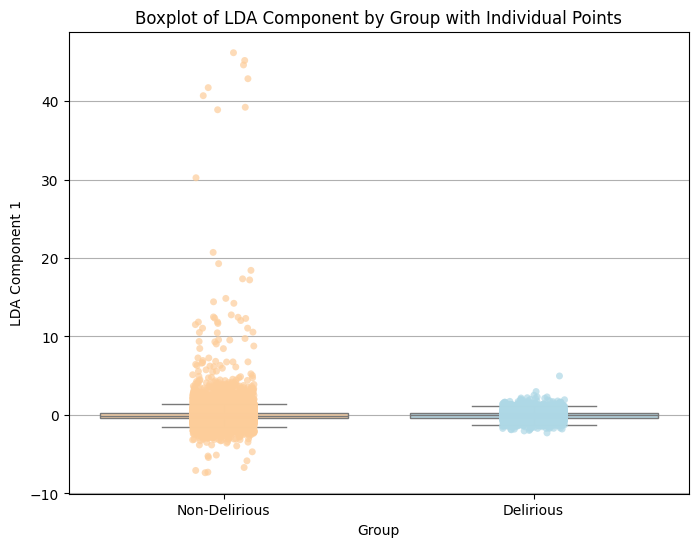

In [7]:
# Separate groups based on labels
control_proj = lda_scores_time[expanded_labels_time.ravel() == 0]  # Non-delirious group
delirium_proj = lda_scores_time[expanded_labels_time.ravel() == 1]  # Delirium group

# Plot mean and standard deviation of LDA projections
# Define custom labels and colors for the groups
group_labels = {0: "Non-Delirious", 1: "Delirious"}
group_colors = ["#fdcd9a","#aed8e6"]  # List of colors corresponding to the groups

# Create a DataFrame for plotting
import pandas as pd
plot_data = pd.DataFrame({
    'Group': [group_labels[label] for label in expanded_labels_time.ravel()],  # Map numeric labels to group names
    'LDA Component 1': lda_scores_time.flatten()  # Flatten LDA projections
})

# Boxplot with individual points
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='LDA Component 1', data=plot_data, palette=group_colors, showfliers=False)
sns.stripplot(x='Group', y='LDA Component 1', data=plot_data, palette=group_colors, jitter=True, alpha=0.7)

# Add title and labels
plt.title('Boxplot of LDA Component by Group with Individual Points')
plt.xlabel('Group')
plt.ylabel('LDA Component 1')
plt.grid(axis='y')  # Add gridlines only to the y-axis for better readability

# Save the figure as an SVG file
output_dir = '/Users/ntaylor/Library/CloudStorage/OneDrive-TheUniversityofSydney(Staff)/Postdoc_Rob/Analysis/Graph_Theory/schaef_400/PCA_LDA/Python/'
output_path = os.path.join(output_dir, f"lda_time_{name_suffix}_boxplot.svg")
plt.savefig(output_path, format="svg", bbox_inches="tight")

plt.show()

In [8]:
#save the LDA coefficients for the ROIs output
print("Current working directory:", os.getcwd())
    # Reshape to (n_rois, 1)
lda_coeff_time_flipped = lda_coefficients_time.reshape(-1, 1)  # Shape: (n_rois, 1)    
    # Create a DataFrame
df = pd.DataFrame(lda_coeff_time_flipped)
    
    # Save the DataFrame to a CSV file with the time point in the filename
output_filename = f'lda_coefficient_weights_overtime_{name_suffix}.csv'
df.to_csv(output_filename, index=False)
    
print(f"Saved: {output_filename}")

Current working directory: /Users/ntaylor/Library/CloudStorage/OneDrive-TheUniversityofSydney(Staff)/Postdoc_Rob/Analysis/Graph_Theory/schaef_400
Saved: lda_coefficient_weights_overtime_mtd_nbm.csv


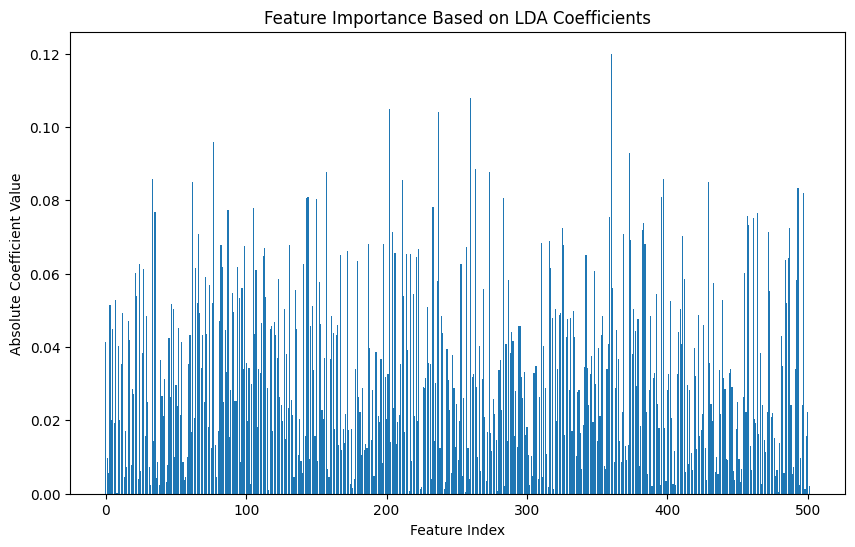

In [9]:
#determine the direction of the coefficients in group separation
# Plot the absolute values of the LDA coefficients
plt.figure(figsize=(10, 6))
plt.bar(range(len(lda_coefficients_time[0])), np.abs(lda_coefficients_time[0]))
plt.title("Feature Importance Based on LDA Coefficients")
plt.xlabel("Feature Index")
plt.ylabel("Absolute Coefficient Value")
plt.show()

Look at the lda scores over time - this will group related differences in the temporal dynamics

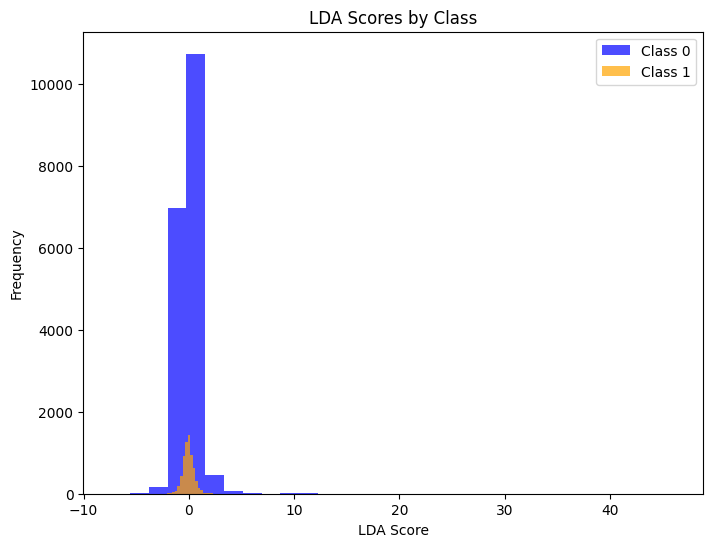

In [10]:
import matplotlib.pyplot as plt

# Plot the LDA scores for each class
plt.figure(figsize=(8, 6))
plt.hist(lda_scores_time[expanded_labels_time == 0], bins=30, alpha=0.7, label="Class 0", color="blue")
plt.hist(lda_scores_time[expanded_labels_time == 1], bins=30, alpha=0.7, label="Class 1", color="orange")
plt.title("LDA Scores by Class")
plt.xlabel("LDA Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Use LDA as ROI-space Reduction
Now, treat lda_coefficients as a projection vector: the direction in ROI space that maximally separates the groups.
- A scalar summary score for each group (via projection onto LDA axis).
- The direction of LDA coefficients tells you which ROIs contributed most.

/var/folders/g9/xqv18td94pz6syfz83n8z70r0000gn/T/ipykernel_4812/2873619049.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Group', y='LDA_Score', palette=['#FDAE61', '#2B83BA'])


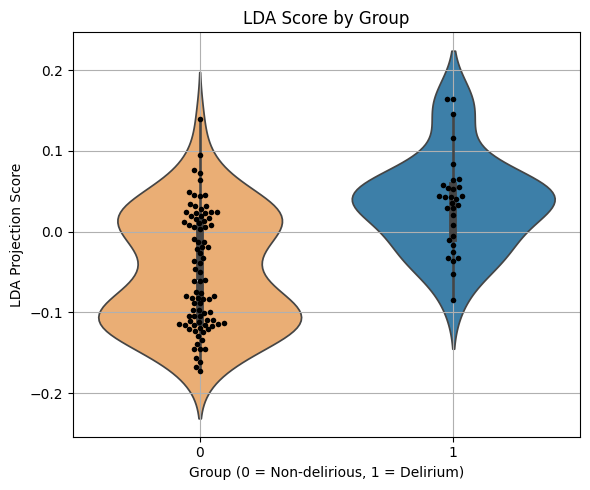

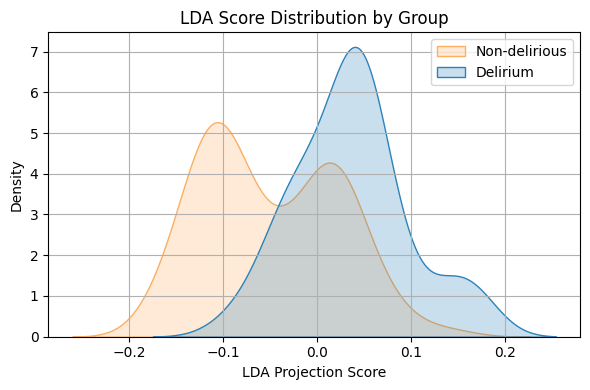

In [11]:
mean_dFC_delirium = data[expanded_labels_time == 1].mean(axis=0)
mean_dFC_nondel = data[expanded_labels_time == 0].mean(axis=0)

# project the group average vectors onto the LDA axis
lda_delirium_proj = np.dot(mean_dFC_delirium, lda_coefficients_time.T)
lda_nondel_proj = np.dot(mean_dFC_nondel, lda_coefficients_time.T)

#try back-projection using LDA coefficients as 'template' ROI weights that define best group separation
data_reshape = data.values.reshape(n_subjects, n_timepoints, n_rois)  # Shape: (subjects, time, ROIs)

subject_mean = data_reshape.mean(axis=1)  # Average across time points for each subject (shape: (subjects, ROIs))
# Project the subject mean onto the LDA coefficients
lda_score_per_subject  = np.dot(subject_mean, lda_coefficients_time.T)  # Shape: (subjects, 1)

# Combine into a DataFrame
df = pd.DataFrame({
    'LDA_Score': lda_score_per_subject.flatten(),  # Ensure 1D array
    'Group': labels.values.flatten()  # Ensure 1D array
})

plt.figure(figsize=(6, 5))
sns.violinplot(data=df, x='Group', y='LDA_Score', palette=['#FDAE61', '#2B83BA'])
sns.swarmplot(data=df, x='Group', y='LDA_Score', color='k', size=4)
plt.xlabel('Group (0 = Non-delirious, 1 = Delirium)')
plt.ylabel('LDA Projection Score')
plt.title('LDA Score by Group')
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 4))
sns.kdeplot(lda_score_per_subject[labels == 0], label='Non-delirious', fill=True, color='#FDAE61')
sns.kdeplot(lda_score_per_subject[labels == 1], label='Delirium', fill=True, color='#2B83BA')
plt.xlabel('LDA Projection Score')
plt.ylabel('Density')
plt.title('LDA Score Distribution by Group')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
print("Mean LDA score (control):", lda_scores_time[expanded_labels_time == 0].mean())
print("Mean LDA score (delirium):", lda_scores_time[expanded_labels_time == 1].mean())

Mean LDA score (control): -0.05656449266171428
Mean LDA score (delirium): 0.16057017271712434


In [12]:
# get incides of control group
nondel_indices = np.where(expanded_labels_time.ravel() == 0)[0]  # Indices of non-delirious group
# get indices of delirium group 
delirium_indices = np.where(expanded_labels_time.ravel() == 1)[0]  # Indices of delirium group

#get lda scores
lda_scores_nondel = lda_scores_time[nondel_indices]  # LDA scores for non-delirious group
lda_scores_delirium = lda_scores_time[delirium_indices]  # LDA scores for delirium group

# Sort and get top-k timepoints (e.g., top 5% of LDA scores in control group)
k = int(0.05 * len(lda_scores_nondel))  # or a fixed number like 100
top_k_indices_within_control = nondel_indices[np.argsort(lda_scores_nondel)[-k:]]
# 3. Select bottom-k timepoints (lowest LDA scores → most delirium-like)
k = int(0.05 * len(lda_scores_delirium))  # or set a fixed number like 100
bottom_k_indices_within_delirium = delirium_indices[np.argsort(lda_scores_delirium)[:k]]
#ge the group-like patterns
nondel_like_pattern = data.values[top_k_indices_within_control,:]  # Mean pattern of top-k non-delirious subjects
mean_nondel_like_pattern = np.mean(nondel_like_pattern, axis=0)  # Mean pattern across top-k subjects

del_like_pattern = data.values[bottom_k_indices_within_delirium,:]  # Mean pattern of top-k non-delirious subjects
mean_del_like_pattern = np.mean(del_like_pattern, axis=0)  # Mean pattern across top-k subjects

In [13]:
# save output of the mean "group-like" patterns
# Convert mean_del_like_pattern to a DataFrame
mean_del_like_pattern_df = pd.DataFrame(mean_del_like_pattern)
mean_del_like_pattern_flip = mean_del_like_pattern.reshape(-1, 1)  # Shape: (n_rois, 1)    
    # Create a DataFrame
df = pd.DataFrame(mean_del_like_pattern_flip)
    
    # Save the DataFrame to a CSV file with the time point in the filename
output_filename = f'LDA_separated_delirium_like_avg_dFC_{name_suffix}.csv'
df.to_csv(output_filename, index=False)
    
print(f"Saved: {output_filename}")


mean_nondel_like_pattern_df = pd.DataFrame(mean_nondel_like_pattern)
mean_nondel_like_pattern_flip = mean_nondel_like_pattern.reshape(-1, 1)  # Shape: (n_rois, 1)    
    # Create a DataFrame
df2 = pd.DataFrame(mean_nondel_like_pattern_flip)
    
    # Save the DataFrame to a CSV file with the time point in the filename
output_filename = f'LDA_separated_nondelirium_like_avg_dFC_{name_suffix}.csv'
df2.to_csv(output_filename, index=False)
    
print(f"Saved: {output_filename}")


## take the delta
mean_diff_del_nondel_like= mean_del_like_pattern - mean_nondel_like_pattern  # Difference between the two patterns
mean_diff_del_nondel_like_flip = mean_diff_del_nondel_like.reshape(-1, 1)  # Shape: (n_rois, 1)    
    # Create a DataFrame
df3 = pd.DataFrame(mean_diff_del_nondel_like_flip)
    
    # Save the DataFrame to a CSV file with the time point in the filename
output_filename = f'LDA_separated_diff_del_nondel_like_avg_dFC_{name_suffix}.csv'
df3.to_csv(output_filename, index=False)
    
print(f"Saved: {output_filename}")

Saved: LDA_separated_delirium_like_avg_dFC_mtd_nbm.csv
Saved: LDA_separated_nondelirium_like_avg_dFC_mtd_nbm.csv
Saved: LDA_separated_diff_del_nondel_like_avg_dFC_mtd_nbm.csv


In [14]:
# Use LDA coefficients as a spatial filter
dot_product = np.dot(data, lda_coefficients_time.T).flatten()  # Flatten to 1D array
#top-k timepoints with the highest LDA scores
top_k_idx = np.argsort(dot_product)[-k:]
top_coeff_like_patterns = data.iloc[top_k_idx]
mean_top_coeff_patterns  = np.mean(top_coeff_like_patterns , axis=0)  # [ROIs]


mean_top_coeff_patterns_flip = mean_top_coeff_patterns.values.reshape(-1, 1)  # Shape: (n_rois, 1)    
    # Create a DataFrame
df_top = pd.DataFrame(mean_top_coeff_patterns_flip)

output_filename = f'LDA_coeffs_weights_select_time_delirium_avg_dFC_{name_suffix}.csv'
df_top.to_csv(output_filename, index=False)
    
print(f"Saved: {output_filename}")


bottom_k_idx = np.argsort(dot_product)[:k]

# Select the patterns corresponding to the bottom-k indices
bottom_coeff_like_patterns = data.iloc[bottom_k_idx]

# Compute the mean pattern across the bottom-k indices
mean_bottom_coeff_patterns = np.mean(bottom_coeff_like_patterns, axis=0)  # [ROIs]

# Reshape the mean pattern to (n_rois, 1)
mean_bottom_coeff_patterns_flip = mean_bottom_coeff_patterns.values.reshape(-1, 1)  # Shape: (n_rois, 1)

# Create a DataFrame
df_bottom = pd.DataFrame(mean_bottom_coeff_patterns_flip)

# Define the output filename
output_filename_bottom = f'LDA_coeffs_weights_select_time_nondelirium_avg_dFC_{name_suffix}.csv'

# Save the DataFrame to a CSV file
df_bottom.to_csv(output_filename_bottom, index=False)

print(f"Saved: {output_filename_bottom}")

Saved: LDA_coeffs_weights_select_time_delirium_avg_dFC_mtd_nbm.csv
Saved: LDA_coeffs_weights_select_time_nondelirium_avg_dFC_mtd_nbm.csv


In [ ]:
#take the delta - still not probably calculating the delta
# Compute the delta (difference) between df_bottom and df_top
#Verify the shapes of the input arrays
assert mean_top_coeff_patterns_flip.shape == mean_bottom_coeff_patterns_flip.shape, "Shapes do not match!"

# Compute the delta (difference)
delta = mean_top_coeff_patterns_flip - mean_bottom_coeff_patterns_flip # Element-wise subtraction

# Print delta to verify
print("Delta (difference):\n", delta)

# Create a DataFrame for the delta
df_delta = pd.DataFrame(delta, columns=["Delta"])

# Print df_delta to verify
print("df_delta:\n", df_delta.head())

# Define the output filename for the delta
output_filename_delta = f'LDA_coeffs_weights_select_time_delta_avg_dFC_{name_suffix}.csv'

# Save the delta DataFrame to a CSV file
df_delta.to_csv(output_filename_delta, index=False)

print(f"Saved delta to: {output_filename_delta}")

Delta (difference):
 [[-7.85111159e-03]
 [ 8.36501157e-03]
 [ 4.49155875e-02]
 [ 4.46008055e-02]
 [ 1.83724254e-01]
 [-1.88315267e-02]
 [ 1.59551806e-02]
 [-3.07700686e-02]
 [ 5.92586523e-02]
 [ 1.14143425e-01]
 [-1.06144919e-01]
 [-1.96290804e-01]
 [-1.79905901e-02]
 [-6.56287962e-02]
 [ 1.95581042e-01]
 [ 4.74110702e-02]
 [ 1.03161444e-01]
 [ 2.75642288e-03]
 [-5.93619329e-02]
 [ 2.61988740e-02]
 [ 2.22482118e-02]
 [-1.05961622e-01]
 [-7.84185361e-02]
 [-1.31014435e-01]
 [-8.42033306e-02]
 [-1.64361506e-01]
 [ 3.17218169e-02]
 [-1.23140476e-03]
 [ 7.43008134e-02]
 [ 1.63065137e-01]
 [-1.20541110e-01]
 [ 7.46991199e-02]
 [-6.19955362e-02]
 [-1.21365432e-02]
 [ 9.59139543e-02]
 [ 1.55194356e-01]
 [ 5.79880478e-02]
 [-9.75693164e-02]
 [ 2.23538492e-02]
 [ 5.80895089e-02]
 [ 3.89301990e-02]
 [ 1.52409050e-01]
 [-1.58413032e-01]
 [-9.05662823e-02]
 [-1.54557305e-01]
 [ 1.63995205e-01]
 [ 3.97353654e-02]
 [ 1.01318280e-01]
 [-1.74493578e-03]
 [-6.50569178e-02]
 [-2.50650449e-02]
 [ 4.90355

## Look at the directional relationship to LDA separation
now that we have the ROIs overtime that are more distinct in separating the two groups - need to determine whether that reflects a functional connectivity difference

1. Try just look at those regional connections for the different groups - separate by the LDA directions

2. Alternatively - look at the LDA separate subjects dFC vs the PC


In [15]:
# Check if nondelirious_mean is less than 0
if nondelirious_mean < 0:
    print("The mean LDA projection for the non-delirious group is less than 0.")
    # Add any additional actions here
else:
    print("The mean LDA projection for the non-delirious group is greater than or equal to 0.")

The mean LDA projection for the non-delirious group is greater than or equal to 0.


In [52]:
# let's look just at the ROIs that are distinctive for the delirium population
# Compute the mean LDA projection for each class

# Get the indices for non-delirium and delirium ROIs
nondelirium_rois = np.where(lda_coefficients_time > 0)[0] # ROIs contributing to non-delirious group


lda_coefficients_time2 = np.array(lda_coefficients_time)

condition = lda_coefficients_time2 < 0
print("Condition (lda_coefficients_time < 0):", condition)
print("Any negative values:", np.any(condition))


delirium_rois = np.where(lda_coefficients_time2 < 0)[0]
print("Delirium ROIs:", delirium_rois)



Condition (lda_coefficients_time < 0): [[ True  True False  True False False False  True  True  True False False
   True False False  True  True  True  True  True False  True False False
   True False False  True  True  True False False False  True  True  True
  False  True False False  True False  True  True False  True False  True
   True  True False  True False  True  True False  True False False False
   True False False False  True False  True  True False  True  True False
   True  True False False False False False False  True False False  True
  False  True  True False  True False False  True  True  True False  True
   True False  True  True False False False False  True False  True False
   True False False False False  True False  True  True False  True False
  False False  True  True False False False False False  True  True  True
   True False False False  True False False  True  True  True  True  True
  False False  True False  True  True False False  True  True False False

## Look at the relationship to participation coefficient
Look at the lda_scores (as its subjects*time) - reshape it to then compare the time-points with higher group differences vs how the pc changes in relation to this

In [25]:
# Identify the top ROIs and time points
from scipy.stats import pearsonr

#load the pc values
#reshaped_features = features.reshape(n_subjects, n_timepoints, n_rois)  # Shape: (subjects, time, ROIs)
pc_data = pd.read_csv('pc_flatten_roi.csv',header=None)  # Replace with your data file subj x time*ROI
pc_sig = pd.read_csv('sig_avg_pc.csv',header=None)  # Replace with your data ROIs 
pc_sig_time = pd.read_csv('sig_permute_pc_time.csv',header=None)  # ROIs x Time

#reshape
pc_data = pc_data.values.reshape(n_subjects, n_timepoints, n_rois)  # Shape: (subjects, time, ROIs)
# Reshape pc_data to flip the dimensions
pc_data_flipped = pc_data.transpose(0, 2, 1)  # Reorder axes: (n_subjects, n_rois, n_timepoints)

# Print the new shape to verify
print(f"Original shape: {pc_data.shape}")
print(f"Flipped shape: {pc_data_flipped.shape}")

#avg of pc across time
pc_avg_time = pc_data.mean(axis=1)  # Average over time, shape: (subjects, ROIs)

# Reshape the DataFrame to (n_subjects, n_timepoints, n_rois)
print(pc_data.shape)
print(pc_sig.shape)
print(pc_sig_time.shape)
print(pc_avg_time.shape)

Original shape: (119, 210, 502)
Flipped shape: (119, 502, 210)
(119, 210, 502)
(502, 1)
(502, 210)
(119, 502)


In [35]:
delirium_pc = pc_avg_time[labels.values.ravel() == 1, :][:, delirium_rois]  # Shape: (n_delirium_subjects, n_delirium_rois)
print(f"Shape of delirium_pc: {delirium_pc.shape}")

Shape of delirium_pc: (31, 240)


Shape of delirium_pc: (31, 240)
Shape of non-delirium_pc: (88, 262)


/var/folders/g9/xqv18td94pz6syfz83n8z70r0000gn/T/ipykernel_4812/2421993938.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=boxplot_labels, patch_artist=True, boxprops=dict(facecolor='lightblue'))


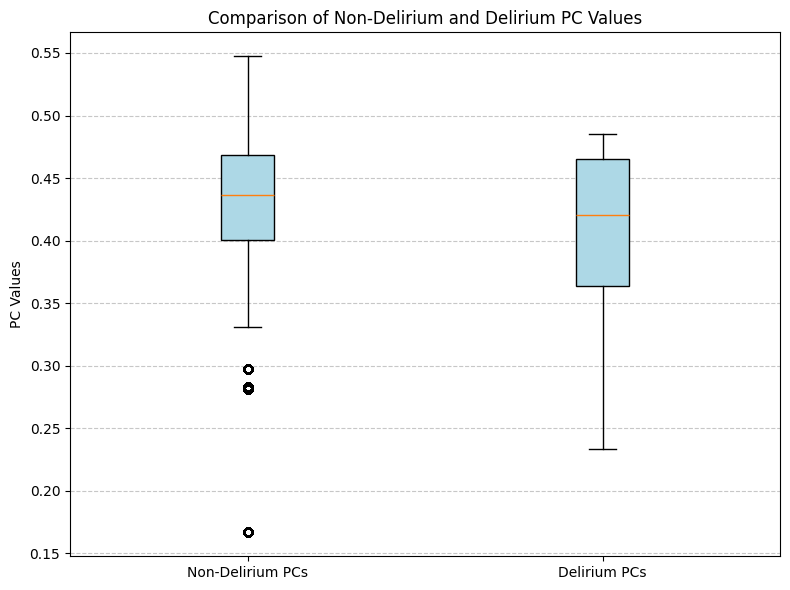

Shape of output_df: (502, 1)


In [ ]:
#comparing the delirium and non-delirium ROIs to the PCs

# ROI IDs - defined by the coefficients of the LDA
nondelirium_rois = np.where(lda_coefficients_time > 0)[0] # ROIs contributing to non-delirious group (negative coefficients
delirium_rois = np.where(lda_coefficients_time <0)[0]

#select the delirium only ROIs for whether they're more segregated
delirium_pc = pc_avg_time[labels.values.ravel() == 1, :][:, delirium_rois] # Shape: (n_delirium_subjects, n_delirium_rois)
print(f"Shape of delirium_pc: {delirium_pc.shape}")
# non-delirium PCs based on the non-delirium ROIs
nondelirium_pc = pc_avg_time[labels.values.ravel() == 0,:][:, nondelirium_rois]  # Shape: (subjects, n_nondelirium_rois)
print(f"Shape of non-delirium_pc: {nondelirium_pc.shape}")
#plot these
# Combine the PC values into a single list for plotting
data_to_plot = [
    nondelirium_pc.flatten(),  # Flatten to combine all non-delirium PC values
    delirium_pc.flatten()      # Flatten to combine all delirium PC values
]

# Create labels for the boxplot
boxplot_labels = ['Non-Delirium PCs', 'Delirium PCs']

# Create the boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(data_to_plot, labels=boxplot_labels, patch_artist=True, boxprops=dict(facecolor='lightblue'))

# Add title and labels
plt.title('Comparison of Non-Delirium and Delirium PC Values')
plt.ylabel('PC Values')
plt.grid(axis='y', linestyle='--', alpha=0.7)


# Save the figure as an SVG file
output_dir = '/Users/ntaylor/Library/CloudStorage/OneDrive-TheUniversityofSydney(Staff)/Postdoc_Rob/Analysis/Graph_Theory/schaef_400/PCA_LDA/Python/'
output_path = os.path.join(output_dir, f"lda_separated_grp_ROIs_pc_{name_suffix}_boxplot.svg")
plt.savefig(output_path, format="svg", bbox_inches="tight")


# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# need to create 502,1 for the avg. PCs - but just for the ROIs that are relevant
# Initialize a DataFrame of size (502, 1) filled with NaN
output_df = pd.DataFrame(np.nan, index=range(502), columns=["Mean_Delirium_PC"])

# Replace the rows corresponding to delirium_rois with mean_delirium_pc
output_df.loc[delirium_rois, "Mean_Delirium_PC"] = mean_delirium_pc_all
print(f"Shape of output_df: {output_df.shape}")

(502,)
Pearson r = -0.050, p = 0.2592


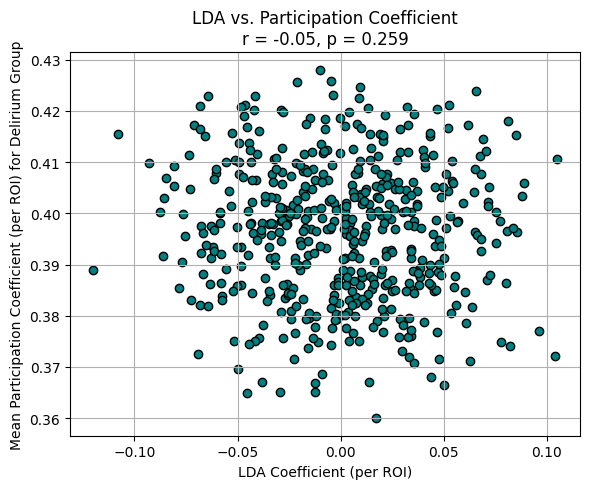

(502,)
Pearson r = -0.018, p = 0.6887


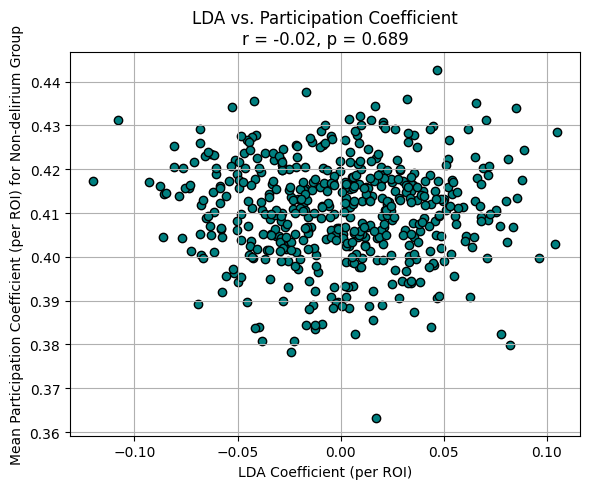

In [42]:
#calculate correlation between lda coefficients overtime and the pc values avg. overtime
from scipy.stats import pearsonr

# 1. Get mean PC across subjects per ROI
mean_delirium_pc_all = pc_avg_time[labels.values.ravel() == 1, :].mean(axis=0)  # Mean PC for delirium group across ROIs
print(mean_delirium_pc_all.shape)
# 2. Correlate with LDA coefficients
r, p = pearsonr(lda_coefficients_time.flatten(),mean_delirium_pc_all)

print(f"Pearson r = {r:.3f}, p = {p:.4f}")

# 3. Visualize
plt.figure(figsize=(6,5))
plt.scatter(lda_coefficients_time,mean_delirium_pc_all, color='teal', edgecolor='k')
plt.ylabel('Mean Participation Coefficient (per ROI) for Delirium Group')
plt.xlabel('LDA Coefficient (per ROI)')
plt.title(f'LDA vs. Participation Coefficient\nr = {r:.2f}, p = {p:.3f}')
plt.grid(True)
plt.tight_layout()
plt.show()

mean_nondel_pc_all = pc_avg_time[labels.values.ravel() == 0, :].mean(axis=0)  # Mean PC for delirium group across ROIs
print(mean_nondel_pc_all.shape)
# 2. Correlate with LDA coefficients
r, p = pearsonr(lda_coefficients_time.flatten(),mean_nondel_pc_all)

print(f"Pearson r = {r:.3f}, p = {p:.4f}")

# 3. Visualize
plt.figure(figsize=(6,5))
plt.scatter(lda_coefficients_time,mean_nondel_pc_all, color='teal', edgecolor='k')
plt.ylabel('Mean Participation Coefficient (per ROI) for Non-delirium Group')
plt.xlabel('LDA Coefficient (per ROI)')
plt.title(f'LDA vs. Participation Coefficient\nr = {r:.2f}, p = {p:.3f}')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# group specific relationships then - LDA separation for the non del vs pc?
# 1. Get mean PC across subjects per ROI
mean_pc_per_roi = pc_avg_time.mean(axis=0)  # shape: (nROIs,)

# 2. Correlate with LDA coefficients
r, p = pearsonr(lda_coefficients_time.flatten(),mean_pc_per_roi)

print(f"Pearson r = {r:.3f}, p = {p:.4f}")

# 3. Visualize
plt.figure(figsize=(6,5))
plt.scatter(lda_coefficients_time,mean_pc_per_roi, color='teal', edgecolor='k')
plt.ylabel('Mean Participation Coefficient (per ROI)')
plt.xlabel('LDA Coefficient (per ROI)')
plt.title(f'LDA vs. Participation Coefficient\nr = {r:.2f}, p = {p:.3f}')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# relationship between the PC and the delirium and non-deirium like patterns
mean_nondel_like_pattern = np.mean(nondel_like_pattern, axis=0)  # Mean pattern across top-k subjects

del_like_pattern = data.values[bottom_k_indices_within_delirium,:]  # Mean pattern of top-k non-delirious subjects
mean_del_like_pattern = np.mean(del_like_pattern, axis=0)  # Mean pattern across top-k subjects

[get_dataset_dir] Dataset found in /Users/ntaylor/nilearn_data/schaefer_2018

/var/folders/g9/xqv18td94pz6syfz83n8z70r0000gn/T/ipykernel_2876/2434008744.py:15: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  atlas_resampled = resample_img(atlas_filename, target_affine=mni_template.affine, target_shape=mni_template.shape, interpolation='nearest')
/var/folders/g9/xqv18td94pz6syfz83n8z70r0000gn/T/ipykernel_2876/2434008744.py:15: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  atlas_resampled = resample_img(atlas_filename, target_affine=mni_template.affine, target_shape=mni_template.shape, interpolation='nearest')
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning: divide by zero encounte

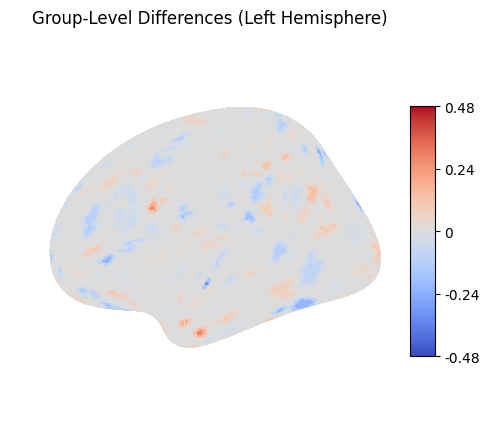

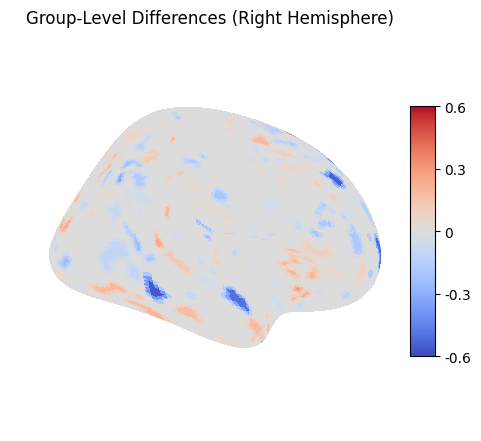

In [19]:
# plot the lda_coefficients_time onto the brain - to see regions that maximally separating the groups
from nilearn import datasets, plotting, surface
from nilearn.image import resample_to_img, resample_img
from nilearn.datasets import load_mni152_template

#roi_data = lda_coefficients_time.flatten()[:400]  # Flatten to 1D array for plotting
roi_data = delta.flatten()[:400]  # Flatten to 1D array for plotting
# Step 1: Load the Schaefer atlas (400 regions, 2mm resolution)
schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=400, resolution_mm=2, yeo_networks=17)
atlas_filename = schaefer['maps']  # Path to the atlas image
roi_labels = schaefer['labels']  # List of ROI labels

# Use the MNI152 template as the target image for resampling
mni_template = load_mni152_template()
atlas_resampled = resample_img(atlas_filename, target_affine=mni_template.affine, target_shape=mni_template.shape, interpolation='nearest')

# Step 3: Map ROI data to the cortical surface
fsaverage = datasets.fetch_surf_fsaverage()

# Map ROI data to surface vertices
texture_left = surface.vol_to_surf(atlas_resampled, fsaverage['pial_left'])
texture_right = surface.vol_to_surf(atlas_resampled, fsaverage['pial_right'])

# Assign ROI data to the texture
# Assuming the atlas maps ROIs 1-400 to the texture, map your data accordingly
texture_left_data = np.zeros_like(texture_left)
texture_right_data = np.zeros_like(texture_right)

for roi_idx, value in enumerate(roi_data):
    texture_left_data[texture_left == roi_idx + 1] = value
    texture_right_data[texture_right == roi_idx + 1] = value

# Step 4: Plot the data on the cortical surface
plotting.plot_surf_stat_map(
    fsaverage['infl_left'],  # Inflated left hemisphere surface
    stat_map=texture_left_data,  # Data to plot
    hemi='left',
    view='lateral',
    colorbar=True,
    title='Group-Level Differences (Left Hemisphere)',
    cmap='coolwarm'
)

plotting.plot_surf_stat_map(
    fsaverage['infl_right'],  # Inflated right hemisphere surface
    stat_map=texture_right_data,  # Data to plot
    hemi='right',
    view='lateral',
    colorbar=True,
    title='Group-Level Differences (Right Hemisphere)',
    cmap='coolwarm'
)

plotting.show()

# Visualize Temporal Trajectories of the LDA

In [ ]:
# Split the LDA projections by group
control_proj = X_lda[expanded_labels == 0]
delirium_proj = X_lda[expanded_labels == 1]

print("Control projection shape:", control_proj.shape)
print("Delirium projection shape:", delirium_proj.shape)

# LDA Model Fitting + Testing Accuracy

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, expanded_labels, test_size=0.2, random_state=42)

# Initialize the Linear Discriminant Analysis model
# Set equal priors to treat classes equally regardless of imbalance - set class priors to be equal to deal with imbalance
lda = LinearDiscriminantAnalysis(priors=[0.5, 0.5])

# Fit the model to the training data
lda.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = lda.predict(X_test)


In [ ]:
# Evaluate the model
from sklearn.metrics import classification_report, roc_auc_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score

print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, lda.predict_proba(X_test)[:, 1]))


lda_coefficients = lda.coef_[0]
print(f"LDA Coefficients Shape: {lda_coefficients.shape}")  # Should be (502,)
print(f"Top contributing features: {np.argsort(np.abs(lda_coefficients))[-10:]}")

# Get the LDA components (useful for temporal pattern analysis)
lda_components = lda.transform(features)  # Shape: (subject * time, n_components)

# Reshape LDA components back to subject x time x components for temporal analysis
lda_components_reshaped = lda_components.reshape(n_subjects, n_timepoints, -1)  # Shape: (subject, time, n_components)

# Print the shape of the transformed data
print(f"LDA-separated data shape: {lda_components.shape}")
print(f"LDA-separated data reshaped shape: {lda_components_reshaped.shape}")


# K-means Clustering
Group-Differentiating Brain States from the dFC